In [1]:
import torch
import numpy as np
from msdlib import msd
import time
import pandas as pd
from IPython.core.display import HTML, display
import seaborn as sns
import utils
import tsp_utils
from tsp_utils import Agent
from config import prepare_tsp_config
from rlutils import solve_agent, inference_config

In [2]:
sns.set()
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')

In [3]:
# getting config
config = prepare_tsp_config(jupyter=True)

Namespace(T=3, active_search=False, alpha=0.99, batch_size=100, c=10, device='cuda', dimension=2, epoch=10000, greedy=False, hidden1=256, hidden2=128, inference=False, iteration=1, loadpath='trained_model/size_20', lr=0.0001, lr_step=50, lr_step_decay=0.999, maximize=False, n_glimpse=1, num_it=1, num_test=100, print_progress=True, problem_size=20, resume_training=False, save_after=100, savepath='trained_model/size_20', start_index=0)


In [4]:
tsp_instances = tsp_utils.generate_tsp_instances(config, inference=True)
tsp_instances.shape

torch.Size([100, 20, 2])

In [5]:
# solutions from all algorithms
solutions = {}

## Ortools solution

In [6]:
or_solutions, or_time = tsp_utils.solve_tsp_ortools(tsp_instances.numpy())
or_distances = tsp_utils.calculate_distances(tsp_instances.numpy(), or_solutions)
solutions['ortools'] = {'solution': or_solutions, 'distance': or_distances, 'time': or_time}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 92.72it/s]


## RL model's solution

epoch: 010000| actor_loss: -0.4076,  critic_loss: 0.0715,  avg_distance: 4.079,  avg_critic_out: 4.012            

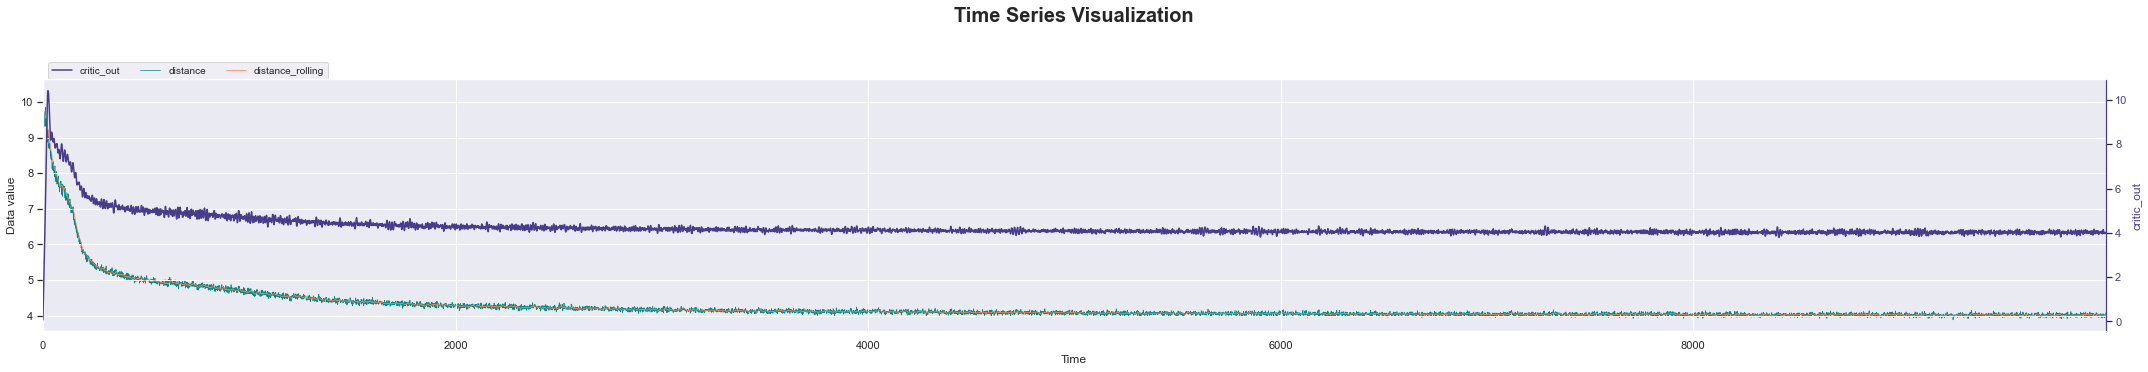

elapsed time:  0 days 00:42:31.214043


In [7]:
t = time.time()
agent = Agent(config)
for i in range(config.epoch):
    data = tsp_utils.generate_tsp_instances(config)
    agent.learn(data)
agent.plot_learning()
print('elapsed time: ', pd.Timedelta(seconds=time.time()-t))

In [8]:
evaluate_func = tsp_utils.calculate_distances
solutions['PN_model'] = solve_agent(agent, tsp_instances, config, evaluate_func, 'distance')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.18it/s]


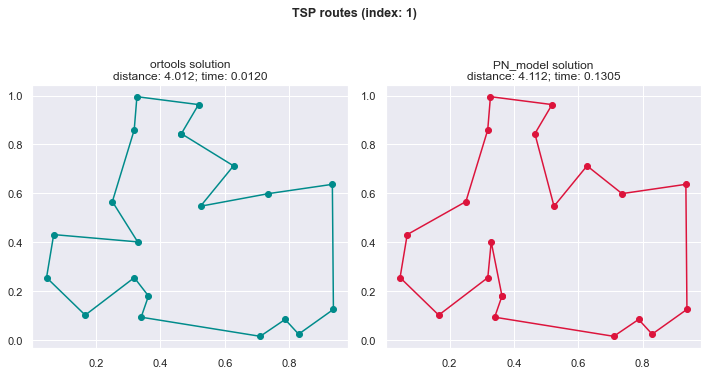

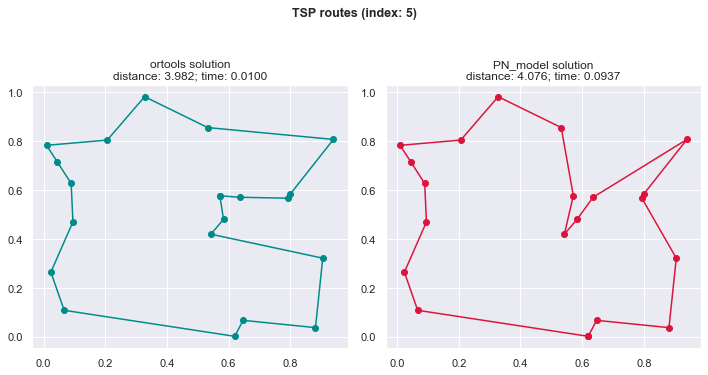

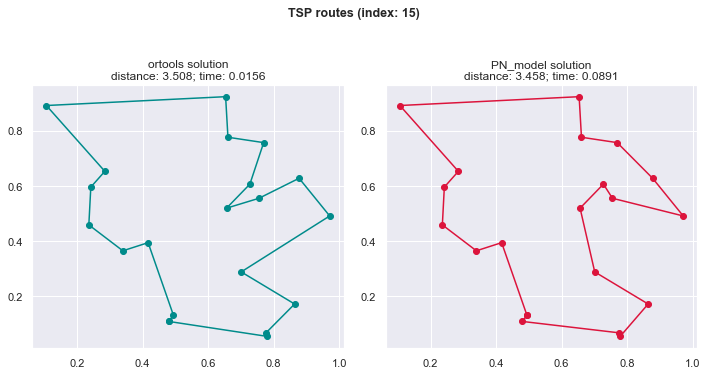

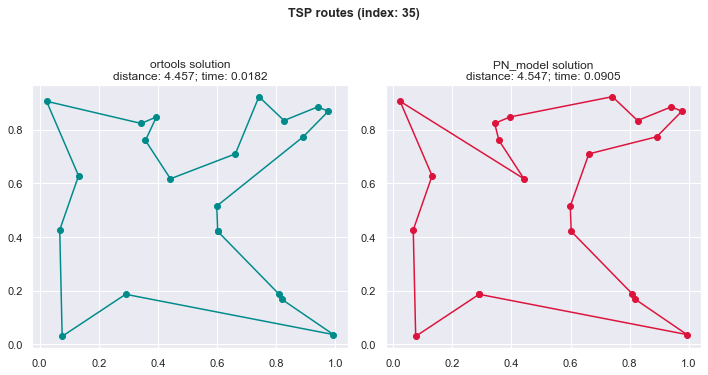

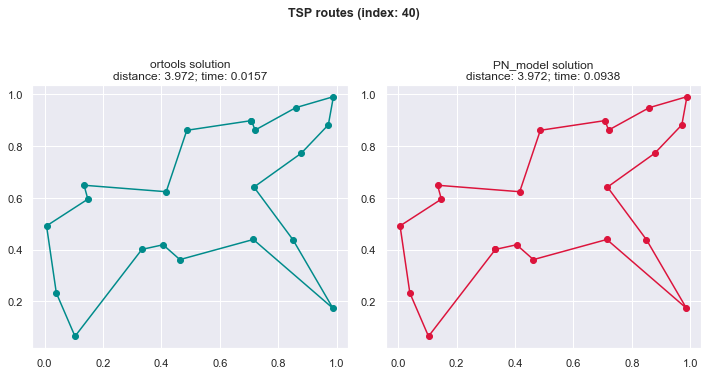

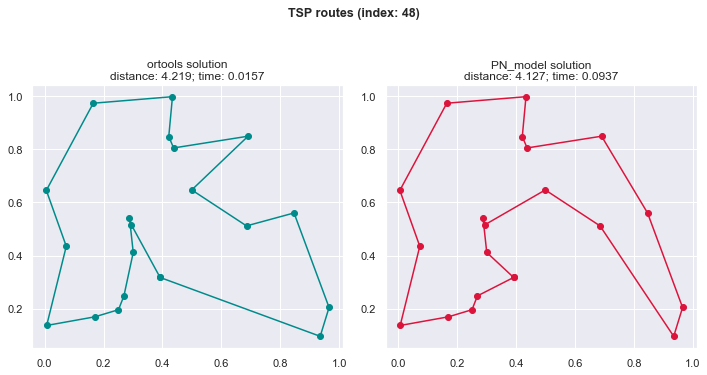

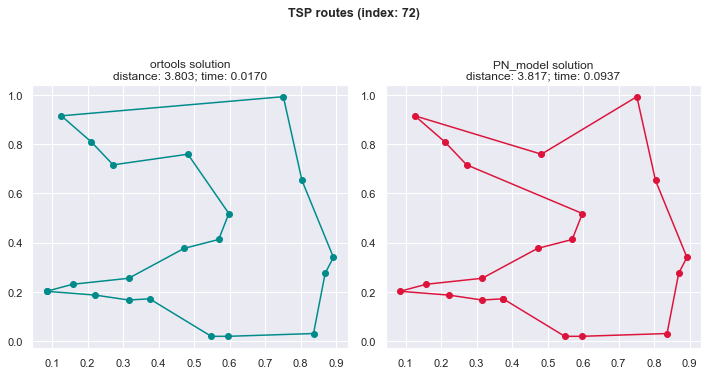

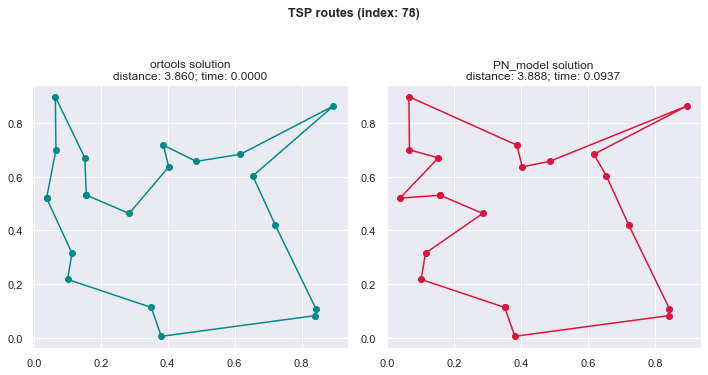

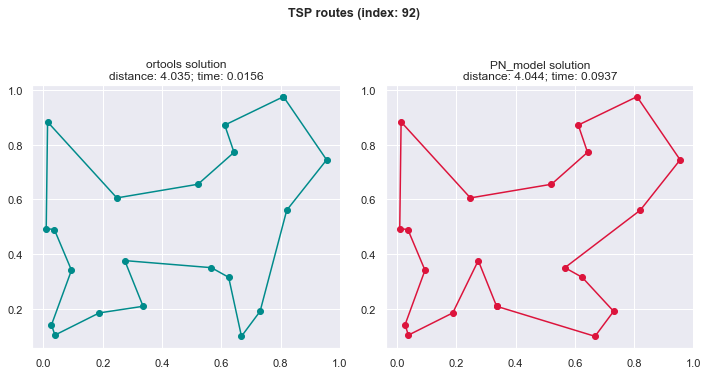

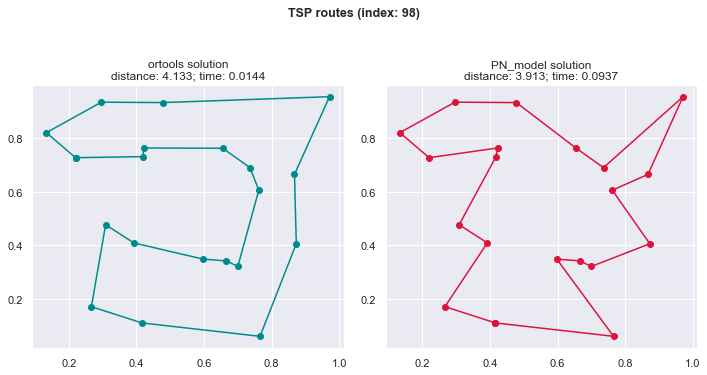

In [9]:
tsp_utils.plot_tsp_solutions(tsp_instances, solutions, 10)

## Results

In [10]:
comp_table = utils.comparison_table(solutions, keyname='distance', maximize=config.maximize)
comp_table

worse            equal         
         ortools PN_model ortools PN_model
ortools        0       55     100       10
PN_model      35        0      10      100

average distance-  ortools: 3.8889;  PN_model: 3.8866;  
average time-  ortools: 0.0107;  PN_model: 0.0980;  
average relative distance-  PN_model: 0.9997;  


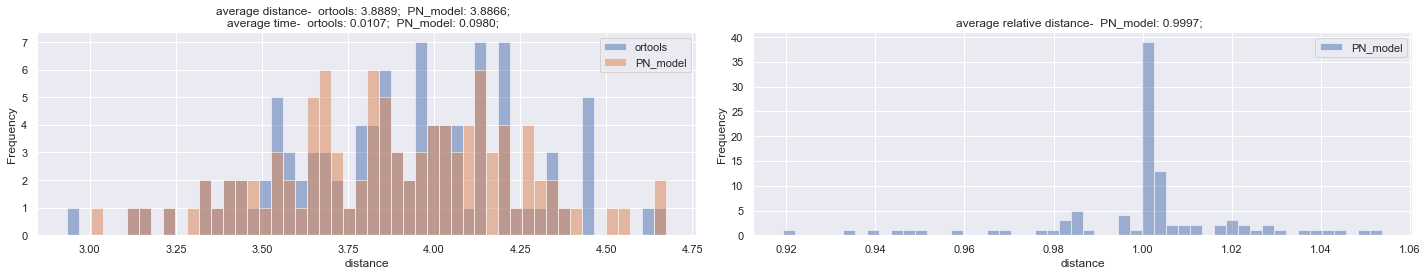

In [11]:
utils.result_stats(solutions, 'distance', basename='ortools', other_keys=['time'])

In [12]:
i = np.random.randint(config.num_test)
print(np.array(solutions['ortools']['solution'][i]))
print(np.array(solutions['PN_model']['solution'][i]))

[ 0 13 11 18  3 17  9  8  4 14 15  1 19  7 10 16  6  5  2 12  0]
[ 5  6 16 10  7 19 15  1 14  8  4 11 13 18  0  3 17  9 12  2  5]


In [3]:
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering, Birch
import matplotlib.pyplot as plt

In [27]:
def plot_clusters(cl_data, cl_labels, means={}, mean_seq={}, solutions=[], show_index=False):
    n_algos = len(cl_labels)
    colors = msd.get_named_colors()
    
    fig, ax = plt.subplots(figsize=(6 * n_algos, 6), ncols=n_algos)
    if n_algos == 1:
        ax = [ax]
    for j, clsname in enumerate(cl_labels):
        for i, n in enumerate(np.sort(np.unique(cl_labels[clsname]))):
            ax[j].scatter(cl_data[clsname][i][:, 0], cl_data[clsname][i][:, 1], color=colors[i])
            ax[j].set_title(clsname)
            if show_index:
                for k in range(cl_data[clsname][i].shape[0]):
                    ax[j].text(cl_data[clsname][i][k, 0], cl_data[clsname][i][k, 1], str(k))
            if len(solutions) > 0:
                xy = cl_data[clsname][i][solutions[clsname][i]]
                ax[j].plot(xy[:, 0], xy[:, 1], color=colors[i])
        if clsname in means and clsname in mean_seq:
            ax[j].plot(means[clsname][:, 0], means[clsname][:, 1], color=colors[-1], marker='o')
        
        if show_index:
            for i in range(means[clsname].shape[0]):
                ax[j].text(means[clsname][i, 0], means[clsname][i, 1], str(i), color=colors[-2], fontweight='bold')
    fig.tight_layout()
    plt.show()

In [5]:
def get_cluster_means(x, labels):
    means = []
    cls_data = []
    cls_indices = []
    for i in np.sort(np.unique(labels)):
        idbool = labels==i
        cls_indices.append(torch.tensor(np.where(idbool)[0]))
        data = x[idbool]
        means.append(data.mean(axis=0))
        cls_data.append(data)
    return torch.stack(means), cls_data, cls_indices

In [6]:
def config_with_size(problem_size):
    config = prepare_tsp_config(show=False, jupyter=True)
    config.problem_size = problem_size
    config.savepath = '_'.join(config.savepath.split('_')[:-1]) + '_%d'%problem_size
    config.loadpath = '_'.join(config.loadpath.split('_')[:-1]) + '_%d'%problem_size
    config.inference = True
    config = inference_config(config)
    return config

In [7]:
def solve_for_cluster(instance):
    
    config = config_with_size(instance.shape[0])
    agent = Agent(config)
    agent.load_weights()

    evaluate_func = tsp_utils.calculate_distances
    solutions = solve_agent(agent, instance.unsqueeze(0), config, evaluate_func, 'distance')
    
    return solutions


In [15]:
x = torch.rand(320, 2)
x

tensor([[0.3390, 0.1030],
        [0.7388, 0.3517],
        [0.0867, 0.3455],
        [0.1898, 0.0342],
        [0.8453, 0.3809],
        [0.1811, 0.6523],
        [0.8308, 0.1118],
        [0.4775, 0.6048],
        [0.2965, 0.7367],
        [0.5749, 0.4761],
        [0.6768, 0.8480],
        [0.1072, 0.1776],
        [0.1456, 0.2217],
        [0.2257, 0.6102],
        [0.4954, 0.8905],
        [0.1027, 0.2289],
        [0.4537, 0.7456],
        [0.9652, 0.0596],
        [0.9273, 0.2228],
        [0.5042, 0.3571],
        [0.8489, 0.0941],
        [0.8590, 0.5102],
        [0.4728, 0.7853],
        [0.5129, 0.7035],
        [0.7648, 0.0764],
        [0.8923, 0.6116],
        [0.3008, 0.8519],
        [0.7523, 0.8598],
        [0.6463, 0.1069],
        [0.4384, 0.9872],
        [0.4202, 0.2395],
        [0.4392, 0.2289],
        [0.7173, 0.6634],
        [0.8452, 0.6149],
        [0.3057, 0.3117],
        [0.7700, 0.8485],
        [0.5335, 0.2189],
        [0.8534, 0.5634],
        [0.9

In [21]:
n_clusters = 6

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


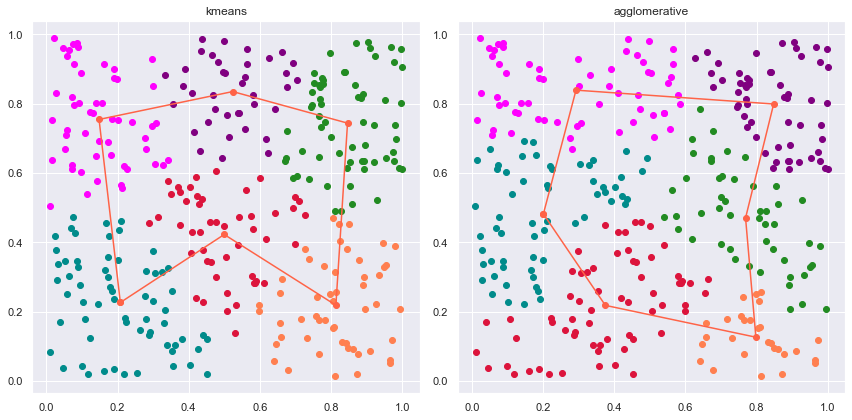

In [22]:
clusters = {'kmeans': KMeans(n_clusters=n_clusters), 
            'agglomerative': AgglomerativeClustering(n_clusters=n_clusters)}
cl_labels = {}
for clsname in clusters:
    clusters[clsname].fit(x)
    cl_labels[clsname] = clusters[clsname].labels_

solmean = {}
plot_solmean = {}
solseq = {}
sollabel = {}
clustered_data = {}
clustered_indices = {}
all_solutions = {}
for algo_name in clusters:

    cl_means, cls_data, cls_indices = get_cluster_means(x, cl_labels[algo_name])

    solution = solve_for_cluster(cl_means)

    solseq[algo_name] = solution['solution'][0]
    solmean[algo_name] = cl_means.squeeze()[solseq[algo_name][:-1]]
    sollabel[algo_name] = cl_labels[algo_name]
    clustered_data[algo_name] = [cls_data[i] for i in solseq[algo_name][:-1]]
    clustered_indices[algo_name] = [cls_indices[i] for i in solseq[algo_name][:-1]]
    plot_solmean[algo_name] = torch.cat((solmean[algo_name], solmean[algo_name][[0]]), 0)
    
    solutions = []
    for i in range(n_clusters):
        sol = solve_for_cluster(clustered_data[algo_name][i])['solution'][0]
        solutions.append(sol)
    all_solutions[algo_name] = solutions.copy()

plot_clusters(clustered_data, sollabel, plot_solmean, solseq)

In [23]:
solmean, solseq

({'kmeans': tensor([[0.2078, 0.2262],
          [0.4998, 0.4223],
          [0.8137, 0.2184],
          [0.8464, 0.7436],
          [0.5237, 0.8347],
          [0.1480, 0.7542]]),
  'agglomerative': tensor([[0.2008, 0.4817],
          [0.3751, 0.2179],
          [0.7981, 0.1261],
          [0.7691, 0.4702],
          [0.8481, 0.7987],
          [0.2926, 0.8387]])},
 {'kmeans': array([2, 4, 5, 1, 3, 0, 2], dtype=int64),
  'agglomerative': array([4, 1, 5, 2, 3, 0, 4], dtype=int64)})

In [24]:
key = 'kmeans'
close_points = {i: {} for i in range(n_clusters)}
for i in range(-1, len(solmean[key]) - 1):
    idx = (solmean[key][i] - clustered_data[key][i+1]).square().sum(axis=1).sqrt().argmin()
    close_points[i if i != -1 else n_clusters - 1][i+1 if i+1 != -1 else n_clusters - 1] = idx
    idx = (solmean[key][i+1] - clustered_data[key][i]).square().sum(axis=1).sqrt().argmin()
    close_points[i+1 if i+1 != -1 else n_clusters - 1][i if i != -1 else n_clusters - 1] = idx

In [25]:
close_points

{0: {5: tensor(14), 1: tensor(3)},
 1: {0: tensor(42), 2: tensor(8)},
 2: {1: tensor(11), 3: tensor(10)},
 3: {2: tensor(9), 4: tensor(15)},
 4: {3: tensor(21), 5: tensor(3)},
 5: {0: tensor(35), 4: tensor(6)}}

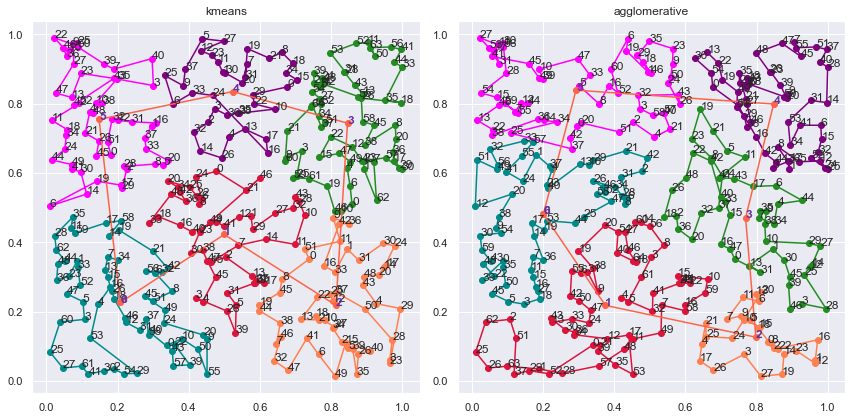

In [28]:
plot_clusters(clustered_data, sollabel, plot_solmean, solseq, all_solutions, True)

In [280]:
all_solutions['kmeans'][0]

array([14,  9,  4, 15,  1, 19, 18, 16,  6,  2,  3, 17,  8,  5,  0, 12, 10,
       11,  7, 13, 14], dtype=int64)

In [281]:
clustered_data['kmeans'][0]

tensor([[0.3782, 0.0723],
        [0.3389, 0.1523],
        [0.3884, 0.1969],
        [0.3920, 0.0422],
        [0.3566, 0.1092],
        [0.4439, 0.0117],
        [0.3023, 0.1602]])

In [65]:
B = 3

In [71]:
size = 50

In [72]:
def cell_prob(h, mask):
    _h = h * 100 - mask * inf
    return torch.softmax(_h, 0)

In [73]:
def cell(x, hc):
    return torch.rand(size), torch.rand(size)

In [74]:
c0 = 0
h0 = 0
x = 0
inf = 10e8

In [78]:
start = 0
c = c0
h = h0
mask = [[0 for _ in range(size)] for _ in range(B)]
acc_probs = [0 for _ in range(B)]
sequences = [[] for _ in range(B)]
hs = [0, 0, 0]
cs = [0, 0, 0]

for i in range(start, size):
#     print('i', i)
    if i == start:
        h, c = cell(x, (h, c))
        p = cell_prob(h, torch.tensor(mask[0]))
        index = np.random.choice(list(range(size)), p=p.detach().cpu().numpy(), size=B, replace=False)
        probs = torch.log(p[index])
        for j in range(B):
            hs[j] = h.clone()
            cs[j] = c.clone()
            acc_probs[j] = probs[j]
            sequences[j].append(index[j])
            mask[j][index[j]] = 1
            
    else:
        seq = [[] for _ in range(B)]
        prob = [[] for _ in range(B)]
        for j in range(B):
            h, c = cell(x, (h, c))
            p = cell_prob(h, torch.tensor(mask[j]))
            if i > size - B:
                index = np.argsort(p)[-B:].tolist()
            else:
                index = np.random.choice(list(range(size)), p=p.detach().cpu().numpy(), size=B, replace=False).tolist()
#             print('index', index)
#             print('probs', p[index])
            probs = torch.log(p[index])
            seq[j] += index
            prob[j] += [acc_probs[j] + probs[k] for k in range(B)]
            
        p = np.exp(np.array([prob[j][k] for j in range(B) for k in range(B)]))
        p = p / p.sum()
        prob_args = np.random.choice(list(range(p.shape[0])), p=p, size=B, replace=False)
#         print('prob_args', prob_args)
#         print('probs', prob)
#         print('seq', seq)
#         input()
        tempseq = sequences.copy()
        tempmask = mask.copy()
        for l in range(B):
            j = prob_args[l] // B
            k = prob_args[l] % B
            sequences[l] = tempseq[j] + [seq[j][k]]
            acc_probs[l] = prob[j][k]
            mask[l] = tempmask[j].copy()
            mask[l][sequences[l][-1]] = 1
#     print('acc_probs: ', [torch.exp(ln) for ln in acc_probs])
#     print('sequences: ', sequences)
#     print('mask: ', mask)
#     input()

In [ ]:
clustered_data

In [194]:
def is_same_side(xy1, xy2, xy3, xy4):
    x1, y1, x2, y2 = xy1[0], xy1[1], xy2[0], xy2[1]
    sign1 = (y1-y2)*xy3[0] - (x1-x2)*xy3[1] + x1*y2 - x2*y1 > 0
    sign2 = (y1-y2)*xy4[0] - (x1-x2)*xy4[1] + x1*y2 - x2*y1 > 0
    if (sign1 and sign2) or (not sign1 and not sign2):
        return True
    return False

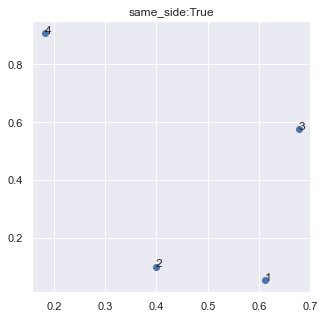

In [195]:
xy = torch.rand(4, 2)

same_side = is_same_side(xy[0], xy[1], xy[2], xy[3])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(xy[:,0], xy[:,1])
ax.set_title('same_side:%s'%same_side)
for i in range(4):
    ax.text(xy[i,0], xy[i,1], str(i+1))
plt.show()

In [37]:
file1.to_csv('C:/Users/abdul/Downloads/file1_processed.csv', index=False)

In [75]:
file1 = pd.read_excel('C:/Users/abdul/Downloads/All emails (1).xlsx')
file1

,Email Address,Email Address.1,Email Address.2,editor@nikkeibp.co.jp,info@kawachiya-print.co.jp,tokhk@netvigator.com,info@ark-net.jp,ymuraoka@hkg.odn.ne.jp
0,Shirai17@gmail.com,Takahashivu@yahoo.com,Aoyama@yahoo.com,webmaster@nikkeibusiness.com,fmail@kingprinting.co.jp,sales1@freebear.co.jp,info@petmokomoko.com,coll.med.komai@nifty.ne.jp
1,Amamiyaqc@gmail.com,Konnotn@yahoo.com,Shihomigb@gmail.com,ecntct@nikkei.co.jp,kurashiki0031@coffee.ocn.ne.jp,matexltd@anet.ne.jp,info@meister-p.jp,biblio@mfj.gr.jp
2,Hamayotsu23@gmail.com,Wakamatsu83@gmail.com,Tagashira66@yahoo.com,press@bloomberg.com,kanei@genshoku.co.jp,kanri@mitsuya-seiko.co.jp,info@marikuro.com,sjdhde@attglobal.net
3,Konoikeuw@yahoo.com,Sawaie@yahoo.com,Asukala@yahoo.com,library@eri.jspmi.or.jp,soumu@kousoku-offset.co.jp,soumu@did-daido.co.jp,music-m@d3.dion.ne.jp,nihongaku@grp.rikkyo.ne.jp
4,Nakagawa68@yahoo.com,Arimotohf@yahoo.com,Kamedaxg@yahoo.com,baa@tokyo.email.ne.jp,webmaster@kohocome.co.jp,webinfo@mitsuboshi.co.jp,info@giga-rensya.com,lib@jpf.go.jp
...,...,...,...,...,...,...,...,...
406541,NaN,Uehashi6@yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN
406542,NaN,Arakawalw@yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN
406543,NaN,Utagawawc@yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN
406544,NaN,Bannowz@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
file1 = pd.concat([file1[f] for f in file1.columns], axis=0)
file1 = file1[~file1.isnull()]
file1

0             Shirai17@gmail.com
1            Amamiyaqc@gmail.com
2          Hamayotsu23@gmail.com
3            Konoikeuw@yahoo.com
4           Nakagawa68@yahoo.com
                  ...           
7937    doll-ty@fb4.so-net.ne.jp
7938        byp05604@nifty.ne.jp
7939              info@mcw.ac.jp
7940             fukyu@ice.or.jp
7941          ma.sa.ru@nifty.com
Length: 1102837, dtype: object

In [80]:
file1 = file1[['@' in f and '.' in f and ',' not in f for f in file1.values]].drop_duplicates()
file1

0             Shirai17@gmail.com
1            Amamiyaqc@gmail.com
2          Hamayotsu23@gmail.com
3            Konoikeuw@yahoo.com
4           Nakagawa68@yahoo.com
                  ...           
7937    doll-ty@fb4.so-net.ne.jp
7938        byp05604@nifty.ne.jp
7939              info@mcw.ac.jp
7940             fukyu@ice.or.jp
7941          ma.sa.ru@nifty.com
Length: 1102549, dtype: object

In [ ]:
size = 10000
i = 0
while True:
    if (i + 1) * size >= file1.shape[0]:
        

In [81]:
file = pd.read_csv('C:/Users/abdul/Downloads/Japan-1 2 3 and opened.csv')
file

C:\Users\abdul\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,Title/Organization/Company,Source,Contact Email Address,Phone,Fax,Address,Zip Code,Country,City,State,Category/Industry,Note
0,10001.0,InfoAvenue - Biz-Horizon,http://www.biz-horizon.com/,biz-horizon@infoavenue.co.jp,NaN,NaN,NaN,NaN,Japan,NaN,NaN,Business_and_Economy/Directories/,"Business news, new product information and sem..."
1,10002.0,NIKKEIBP JP - NIKKEIBP.JP,http://www.nikkeibp.jp/,editor@nikkeibp.co.jp,NaN,NaN,NaN,NaN,Japan,NaN,NaN,News/Business/,It transmits general business news.
2,10003.0,"NIKKEI NET BizPlus - Nihon Keizai Shimbun, Inc.",http://bizplus.nikkei.co.jp/,NaN,NaN,NaN,NaN,NaN,Japan,NaN,NaN,Business_and_Economy/Directories/,"News and serialization article, Q&A of busines..."
3,10004.0,Nikkei business,http://nb.nikkeibp.co.jp/,webmaster@nikkeibusiness.com,03-5696-1111,NaN,NaN,NaN,Japan,NaN,NaN,Business_and_Economy/Magazines/,News story and the like of just published.
4,10005.0,The Japanese economic newspaper,http://www.nikkei.co.jp/,ecntct@nikkei.co.jp,-7489,-7808,1-9-5 Otemachi Chiyoda-ku Tokyo 100-8066,100-8066,Japan,NaN,NaN,Business_and_Economy/Shopping_and_Services/New...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
788178,NaN,NaN,NaN,v.pungartnik@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788179,NaN,NaN,NaN,hidenori.higuchi@i.softbank.jp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788180,NaN,NaN,NaN,ajavier524@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788181,NaN,NaN,NaN,jinji.golf@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
keep = ['tokyo', 'saitama', 'chiba', 'kanagawa']
key = 'Contact Email Address'

In [91]:
secs = []
for k in keep:
    secs.append(file[file['State'].str.lower() == k])

file = pd.concat(secs, axis=0)
file

,ID,Title/Organization/Company,Source,Contact Email Address,Phone,Fax,Address,Zip Code,Country,City,State,Category/Industry,Note
12,10014.0,"Japan Automobile Manufacturers Association, In...",http://www.jama.or.jp/lib/car_library/,NaN,03-5405-6139,NaN,NaN,105-0012,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,"The internal book related to automobile, to co..."
13,10015.0,The Shinagawa ward Osaki library business supp...,http://lib.city.shinagawa.tokyo.jp/bl/osaki_bl...,osaki-bl@city.shinagawa.tokyo.jp,03-3524-4668,03-3666-9810,NaN,141-0032,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,"The books, the newspaper, the magazine and the..."
15,10017.0,The Non-Life Insurance Institute of Japan - Pr...,http://www.sonposoken.or.jp/library/,kaigaikensyu@sonposoken.or.jp,+81 (0)3 3255-5511,+81 (0)3 3255-1449,"9, Kanda Awajicho 2-Chome, Chiyoda-ku, Tokyo 1...",101-8335,Japan,Chiyoda-ku,Tokyo,Business_and_Economy/Business_Libraries/,Loss preservation entire research library. OPA...
16,10018.0,Tokyo Chamber of Commerce and Industry economi...,http://www.tokyo-cci.or.jp/side_m/sisetu/keiza...,library@tokyo-cci.or.jp,NaN,NaN,NaN,NaN,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,Possession data information and the like.
17,10019.0,Japan Business History Institute - The Japanes...,http://www.jbhi.or.jp/library.html,library@jbhi.or.jp,03-3262-1090,03-3239-5090,NaN,102-0093,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,Company history (company history) the collecti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363252,580014.0,MARUEM TECHNO CORP,http://www.fujicell.net,alexintel@hotmail.com,81-44-9349911,81-44-9349912,"1-10-1, Masugata,",2140032,Japan,Kawasaki-shi,Kanagawa,NaN,"All Kinds Alkaline, Heavy Duty, Rapid Battery ..."
363254,580018.0,GLOBAL ACQUIRERS INTERNATIONAL CO LTD,http://www.globalacq.jp,sales@globalacq.jp,0081-4-4567-1893,0081-4-4572-4520,"Tama Ku, Noborito 3151-1-205",228-0803,Japan,Kawasaki,Kanagawa,NaN,"Used Japanese Vehicles,Used Foreign Vehicles,U..."
363271,580054.0,AIT JAPAN CO LTD,http://www.aitjapan.co.jp/english,NaN,81-45-2120190,81-45-212-0199,"1009 Glorio Tower Yamashita, Naka-ku",231-0023,Japan,Yokohama-shi,Kanagawa,NaN,"Marine Engine, Construct"
363273,580058.0,Sakura Corporation,http://www.sakura-aircon.com,mail@sakura-aircon.com,81-45-9498550,81-45-9598551,2-17-1eda-Minami Tsuzuki-Ku,224-0007,Japan,Yokohama,Kanagawa,NaN,"Full Range Of Air Conditioners, Air Conditioni..."


In [93]:
file = file[~file[key].isnull()]
file = file[['@' in f and '.' in f and ',' not in f for f in file[key].values]]
file

,ID,Title/Organization/Company,Source,Contact Email Address,Phone,Fax,Address,Zip Code,Country,City,State,Category/Industry,Note
13,10015.0,The Shinagawa ward Osaki library business supp...,http://lib.city.shinagawa.tokyo.jp/bl/osaki_bl...,osaki-bl@city.shinagawa.tokyo.jp,03-3524-4668,03-3666-9810,NaN,141-0032,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,"The books, the newspaper, the magazine and the..."
15,10017.0,The Non-Life Insurance Institute of Japan - Pr...,http://www.sonposoken.or.jp/library/,kaigaikensyu@sonposoken.or.jp,+81 (0)3 3255-5511,+81 (0)3 3255-1449,"9, Kanda Awajicho 2-Chome, Chiyoda-ku, Tokyo 1...",101-8335,Japan,Chiyoda-ku,Tokyo,Business_and_Economy/Business_Libraries/,Loss preservation entire research library. OPA...
16,10018.0,Tokyo Chamber of Commerce and Industry economi...,http://www.tokyo-cci.or.jp/side_m/sisetu/keiza...,library@tokyo-cci.or.jp,NaN,NaN,NaN,NaN,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,Possession data information and the like.
17,10019.0,Japan Business History Institute - The Japanes...,http://www.jbhi.or.jp/library.html,library@jbhi.or.jp,03-3262-1090,03-3239-5090,NaN,102-0093,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,Company history (company history) the collecti...
18,10020.0,Hosei university innovational & management res...,http://www.hosei.ac.jp/fujimi/sanzyo/,cbir@i.hosei.ac.jp,03-3264-9420,03-3264-4690,NaN,102-8160,Japan,NaN,Tokyo,Business_and_Economy/Business_Libraries/,The guide of the data center which possesses c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363198,579892.0,"Margomar Co., Ltd",http://www.margomar.com,margo@margomar.com,81-045-5544652,81-045-5952652,Tsuzukiku Minamiyamada 3-15-24,2240029,Japan,Yokohama,Kanagawa,NaN,"lady wear,Fashion,clothings"
363252,580014.0,MARUEM TECHNO CORP,http://www.fujicell.net,alexintel@hotmail.com,81-44-9349911,81-44-9349912,"1-10-1, Masugata,",2140032,Japan,Kawasaki-shi,Kanagawa,NaN,"All Kinds Alkaline, Heavy Duty, Rapid Battery ..."
363254,580018.0,GLOBAL ACQUIRERS INTERNATIONAL CO LTD,http://www.globalacq.jp,sales@globalacq.jp,0081-4-4567-1893,0081-4-4572-4520,"Tama Ku, Noborito 3151-1-205",228-0803,Japan,Kawasaki,Kanagawa,NaN,"Used Japanese Vehicles,Used Foreign Vehicles,U..."
363273,580058.0,Sakura Corporation,http://www.sakura-aircon.com,mail@sakura-aircon.com,81-45-9498550,81-45-9598551,2-17-1eda-Minami Tsuzuki-Ku,224-0007,Japan,Yokohama,Kanagawa,NaN,"Full Range Of Air Conditioners, Air Conditioni..."


In [95]:
file['State'] = file['State'].str.lower()
file['State'].value_counts()

tokyo       27725
kanagawa     8760
saitama      5022
chiba        4147
Name: State, dtype: int64

In [97]:
file.drop_duplicates([key], keep='first', inplace=True)

In [101]:
size = 5000
for k in keep:
    fl = file[file['State']==k]
    i = 0
    while True:
        if (i+1) * size > fl.shape[0]:
            flsave = fl.iloc[i*size:]
            flsave[[key]].to_csv('C:/Users/abdul/Downloads/processed_emails, %s_%d.csv'%(k, i+1))
            break
        else:
            flsave = fl.iloc[i*size: (i+1)*size]
            flsave[[key]].to_csv('C:/Users/abdul/Downloads/processed_emails, %s_%d.csv'%(k, i+1))
        i += 1

In [41]:
n = 4
segsize = file1.shape[0] // n
for i in range(n):
    file1.iloc[segsize*i: segsize*(i+1)].to_csv('C:/Users/abdul/Downloads/file1_processed_%d.csv'%(i+1), index=False)